# Chest X-Ray Pneumonia Classification

##### Griffin Hundley, Malcolm Katzenbach

<img src = '../images/1200px-Normal_posteroanterior_(PA)_chest_radiograph_(X-ray).jpg' width = 400 />

## Business Problem

There are about a million adults in the US that have to be admitted to the hospital for pneumonia. Of those, 50,000 may die in year. One of the tests medical professionals can conduct to test for pneumonia is a chest x-ray scan. By creating a classification model that can predict if a x-ray indicates pneumonia or not, we can help medical professionals make a diagnosis for the patient faster and get to treatment more quickly, thus possibly saving lives.

## Exploratory Data Analysis

In this project we will be building an image classification model that classifies chest x-ray images as `normal` or `pneumonia`.  The model is trained on over 5000 images, from D. Kermany et al DOI:10.17632/rscbjbr9sj.3.

The images in this dataset were split into a training set, a validation set, and a test set. In the training set, there is a large class imbalance with 1299 `normal` x-ray images and 3833 x-ray images with `pnuemonia`. The validation set has no class imbalance with 50 `normal` x-ray images and 50 x-ray images with `pnuemonia`. The test set has a small imbalance with 234 `normal` x-ray images and 390 x-ray images with `pnuemonia`.

In [9]:
import matplotlib.pyplot as plt
import os

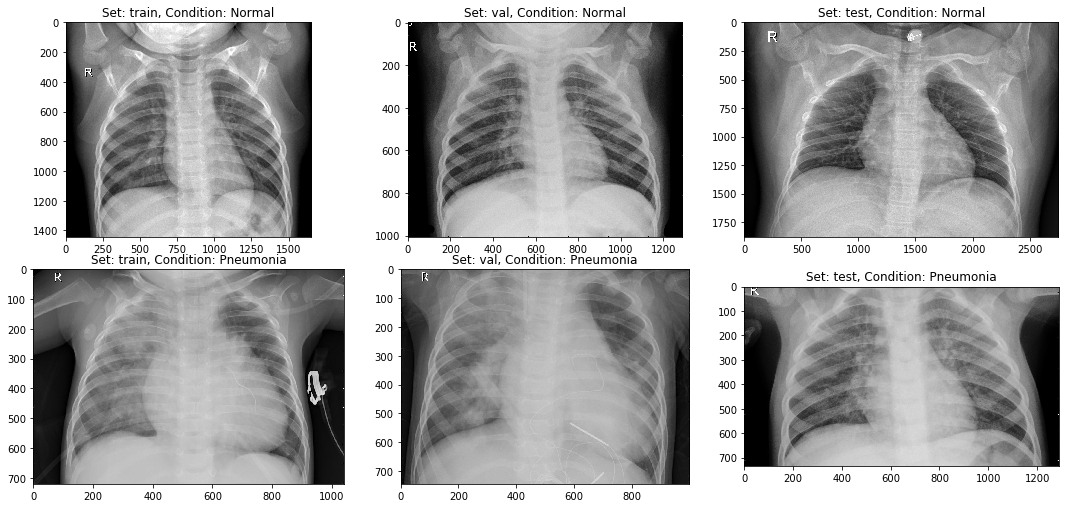

In [11]:
input_path = '../data/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))
# fig.savefig('../images/chestxrays.png', bbox_inches='tight')

Visualizing one image from each class and set. From the images, we can tell there is a difference between the `normal` and `pnuemonia` x-ray images. The `pnuemonia` images are generally fuzzy or less clear in the lung regions. When radiologists look at chest x-ray image, one of the indicators of `pnuemonia` that they look for is the "ground-glass opacities". It describes the different shades of grey that can be found in between an normal chest x-ray and a chest x-ray of a patient with pnuemonia. As in the cases above, the `normal` images show clear lungs while in the `pnuemonia` images, there is an opacity in certain areas of the lung. In addition to opacities, there may be other features such as white spots, abcesses, fluid cavities, etc which may be indicative of pneumonia which the model may identify and use to classify the x-ray.

## Modelling 

#### Import Necessary Libraries and Modules

In [3]:
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras import models, Input, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, SeparableConv2D, Activation
from keras.optimizers import Adam
from keras.metrics import Recall, Precision, AUC
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

#### Import Data and Create Training, Validation, and Test Groups

In [4]:
# Instantiate a Keras Image Data Generator. Pixel Intensity is between 0 and 255, thus we rescale 
# to normalize pixel intensity
datagen = ImageDataGenerator(rescale = 1./255)
# Import a train group. There are normal and pnuemonia images, thus class_mode is binary. We resize the images
# to one specific size by setting the target size to 64 pixels by 64 pixels. The batch size is the total image 
# number.
train_it = datagen.flow_from_directory('../data/train/',
                                       class_mode='binary',
                                       target_size = (64,64),
                                       batch_size = 5132)
# Repeat of above, but importing the validation group
val_it = datagen.flow_from_directory('../data/val/',
                                     class_mode='binary',
                                     target_size = (64,64),
                                     batch_size = 100)
# Repeat of above, but importing the test group
test_it = datagen.flow_from_directory('../data/test/',
                                      class_mode='binary', 
                                      target_size = (64,64),
                                      batch_size = 624)
# Split the groups into images (X) and class (Y)
X_train, Y_train = train_it.next()
X_val, Y_val = val_it.next()
X_test, Y_test = test_it.next()

# Our model has an single output, so we reshape the Y values into a single column
Y_train = Y_train.reshape(5132,1)
Y_val = Y_val.reshape(100,1)
Y_test = Y_test.reshape(624,1)

Found 5132 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#### Final Model

Our final model uses a convolutional neural net (CNN). In the context of image classification, CNN tend to perform better. The final model has 3 2D neural nets and 2 fully connected layers  with `relu` activation. The output layer is a single dense binary output with a `sigmoid` activation. For model diagnostics, we measured accuracy, precision, recall, and the AUC score. Due to the medical application of this model, the most important metric is the recall, because we want to minimize false negatives (we would rather predict a healthy patient has pneumonia than predict someone with pneumonia as healthy, and followup bloodwork can confirm this result).

In [ ]:
# Instantiate sequential neural net
model = models.Sequential()

# first layer - convolutional 2d NN with relu activation, 3x3 kernal size, drops out 20% of neural nodes to 
# combat over-fitting
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64 ,64,  3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

# second layer - convolutional 2d NN with relu activation, 3x3 kernal size, drops out 20% of neural nodes to 
# combat over-fitting
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

# third layer - convolutional 2d NN with relu activation, 3x3 kernal size, drops out 20% of neural nodes to 
# combat over-fitting
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

# flattens the 2D input into a 1D input for the dense layer
model.add(Flatten())

# fourth layer - two dense layers with relu activation, drops out 20% of neural nodes to combat over-fitting
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(1, activation='sigmoid'))

# compiled with adaptive moment estimation (adam), with binary cross-entropy loss function
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc', Precision(), Recall(), AUC()])

# Fit model with training group and validation group
history = model.fit(X_train,
                    Y_train,
                    epochs=5,
                    batch_size = 32,
                    validation_data=(X_val, Y_val))

# Evaaluate model using test group
# score = model.evaluate(X_test, Y_test, verbose=0)

# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
# print('Test precision:', score[2])
# print('Test recall:', score[3])
# print('Test AUC:', score[4])

In [ ]:
from keras.utils.vis_utils import plot_model
# create a visualization of the model architecture
plot_model(loaded_model, show_layer_names = False)

## Results

With the final iteration of the model, a recall score of 0.99 was achieved, predicting nearly all of the true positives for chest x-rays with pneumonia.  The accuracy was 0.89, with a precision of 0.85.

In [15]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
# load saved model
loaded_model = load_model('best_model.h5')
# generate predictions from the model with a threshhold of 0.6
y_pred = (loaded_model.predict(X_test) > 0.6)
# create confusion matrix array from predictions
cm = confusion_matrix(Y_test, y_pred)

In [16]:
# generate scores for the model
score = loaded_model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
print('Test AUC:', score[4])

Test loss: 0.4935239553451538
Test accuracy: 0.8894230723381042
Test precision: 0.8543046116828918
Test recall: 0.9923076629638672
Test AUC: 0.9413378834724426


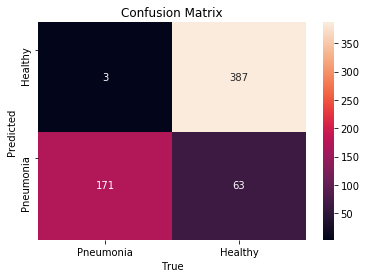

In [18]:
import seaborn as sns
# plot the confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_test, y_pred),
            annot = True,
            ax = ax,
            fmt = 'd')
ax.set_ylim([0,2])
ax.set_yticks([0.75, 1.75])
ax.set_title('Confusion Matrix')
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
ax.yaxis.set_ticklabels(['Pneumonia', 'Healthy'])
ax.xaxis.set_ticklabels(['Pneumonia', 'Healthy'])
# fig.savefig('../images/confmatrix.png', bbox_inches='tight')

## Conclusions and Future Steps

With a recall score of 0.99, almost all of the true positive cases are detected.  By adjusting the threshhold for the classifier, the results can be tuned for other desired metrics as well.  Adjusting the threshhold from 0.5 to 0.6 does not increase the number of false negatives but reduces the number of false positives.  This model performs well as net to catch potential infections that a radiologist might miss on visual inspection.

Some of the limitations of this model are that certain non-pneumonia features may resemble pneumonia features in a chest x-ray. According to C. Gibson et al., lung scaring and congenital heart failure have similar features to pneumonia in an x-ray image, which would result in false positives.  Additionally, pneumonia may occupy regions of the lung not visible in the x-ray.  They also claim that chest x-rays are nonspecific when diagnosing viral pneumonia, which would result in false negatives for viral pneumonia.

Future improvements to the model could be potential random transformations to the images such as vertical flip, rotations, zoom, and shift, to eliminate sensitivity to differences in the field of view of the image.  

Additionally, this model downscales images to 64 x 64 pixels, reducing the amount of detail in an image to increase computation speed.  A model that trains on higher resolution images will potentially see features that require more definition.  